### Description: In this script we will be visualizing some historical flood events (2020) in Kenya using Google Flood Hub's historical reanalysis discharge data. 

###### Code is adapted from the following tutorial https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing#scrollTo=UTbokLLWp_9o

#### Step 1: Import Libraries

In [9]:
import datetime
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs

#### Step 2: Load Files

In [10]:
# Function for opening zarr datasets
def open_zarr(path):
  return xr.open_zarr(
      store=path,
      chunks=None,
      storage_options=dict(token='anon')
      )

In [11]:
# Set file paths
base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'
reforecast_path = os.path.join(base_directory, 'reforecast/streamflow.zarr/')
reanalysis_path = os.path.join(base_directory, 'reanalysis/streamflow.zarr/')
return_periods_path = os.path.join(base_directory, 'return_periods.zarr/')

In [12]:
# Load files
reforecast_ds = open_zarr(reforecast_path)
reanalysis_ds = open_zarr(reanalysis_path)
return_periods_ds = open_zarr(return_periods_path)

print(f'{reforecast_ds.sizes = }')
print(f'{reanalysis_ds.sizes = }')
print(f'{return_periods_ds.sizes = }')

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_21884\3731592437.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})
reanalysis_ds.sizes = Frozen({'gauge_id': 1031646, 'time': 16063})
return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


#### Step 3: Load for a HydroBasin

In [28]:
# hybas_id = "hybas_1121173070" # Nairobi, Kenya
hybas_id = "hybas_1122086600" # Garissa, Kenya
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()

#### Step 4: Plots

##### Plotting functions

In [85]:
def add_thresholds(ax, gauge_return_periods_ds, thresholds):
  colors = ('yellow', 'orange', 'red', 'brown', 'black')
  for threshold, color in zip(thresholds, colors):
    ax.axhline(
      y=gauge_return_periods_ds[f'return_period_{threshold}'].item(), color=color, label=f'{threshold} year return period', linestyle='--'
    )

def plot_reanalysis(start_date, end_date, gauge_return_periods_ds, thresholds=('2', '5', '20', '50', '100')):
  fig, ax = plt.subplots(figsize=(30, 6))
  gauge_reanalysis_da = gauge_reanalysis_ds.streamflow.sel(time=slice(start_date, end_date))
  ax.plot(gauge_reanalysis_da.time, gauge_reanalysis_da.values)
  add_thresholds(ax, gauge_return_periods_ds, thresholds)
  plt.legend(loc='upper right')
  plt.show()


def plot_reforecast(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds, thresholds=('2', '5', '20', '50', '100')):
  fig, ax = plt.subplots(figsize=(30, 6))
  # For each issue date, we plot the precipitation forecast as a forecast hair.
  for issue_time in gauge_reforecast_ds.sel(issue_time=slice(issue_time_start_date, issue_time_end_date))['issue_time']:
    issue_time_slice = gauge_reforecast_ds.sel(issue_time=issue_time)

    # Get the date for each lead time.
    lead_time_to_dates = [pd.to_datetime(issue_time.values) + datetime.timedelta(seconds=(lead_time.item() // 10**9)) for lead_time in issue_time_slice['lead_time']]

    # Plot the forecast aligned to the dates.
    ax.plot(lead_time_to_dates, issue_time_slice.streamflow.values)

  add_thresholds(ax, gauge_return_periods_ds, thresholds)
  plt.legend(loc='upper right')
  plt.show()

def plot_reforecast_leadtime(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds, leadtime='7 days', thresholds=('2', '5', '20', '50', '100')):
  fig, ax = plt.subplots(figsize=(30, 6))

  # Convert lead time string to timedelta
  lead_time_delta = pd.to_timedelta(leadtime)
  # slice datasset for specified issue time range
  issue_time_slice = gauge_reforecast_ds.sel(issue_time=slice(issue_time_start_date, issue_time_end_date))
  # Compute dates and streamflow values for the selected lead time
  dates = pd.to_datetime(issue_time_slice['issue_time'].values) + lead_time_delta
  streamflow_values = issue_time_slice.sel(lead_time=lead_time_delta, method='nearest').streamflow.values

  # Plot as a line graph (time series)
  plt.plot(dates, streamflow_values, linestyle='-')

  # Add thresholds if available
  add_thresholds(ax=plt.gca(), gauge_return_periods_ds=gauge_return_periods_ds, thresholds=thresholds)

  # Formatting
  plt.title(f"Reforecast at {leadtime} lead time")
  plt.xlabel("Date")
  plt.ylabel("Streamflow")
  plt.legend()
  plt.show()

##### Plot reanalysis

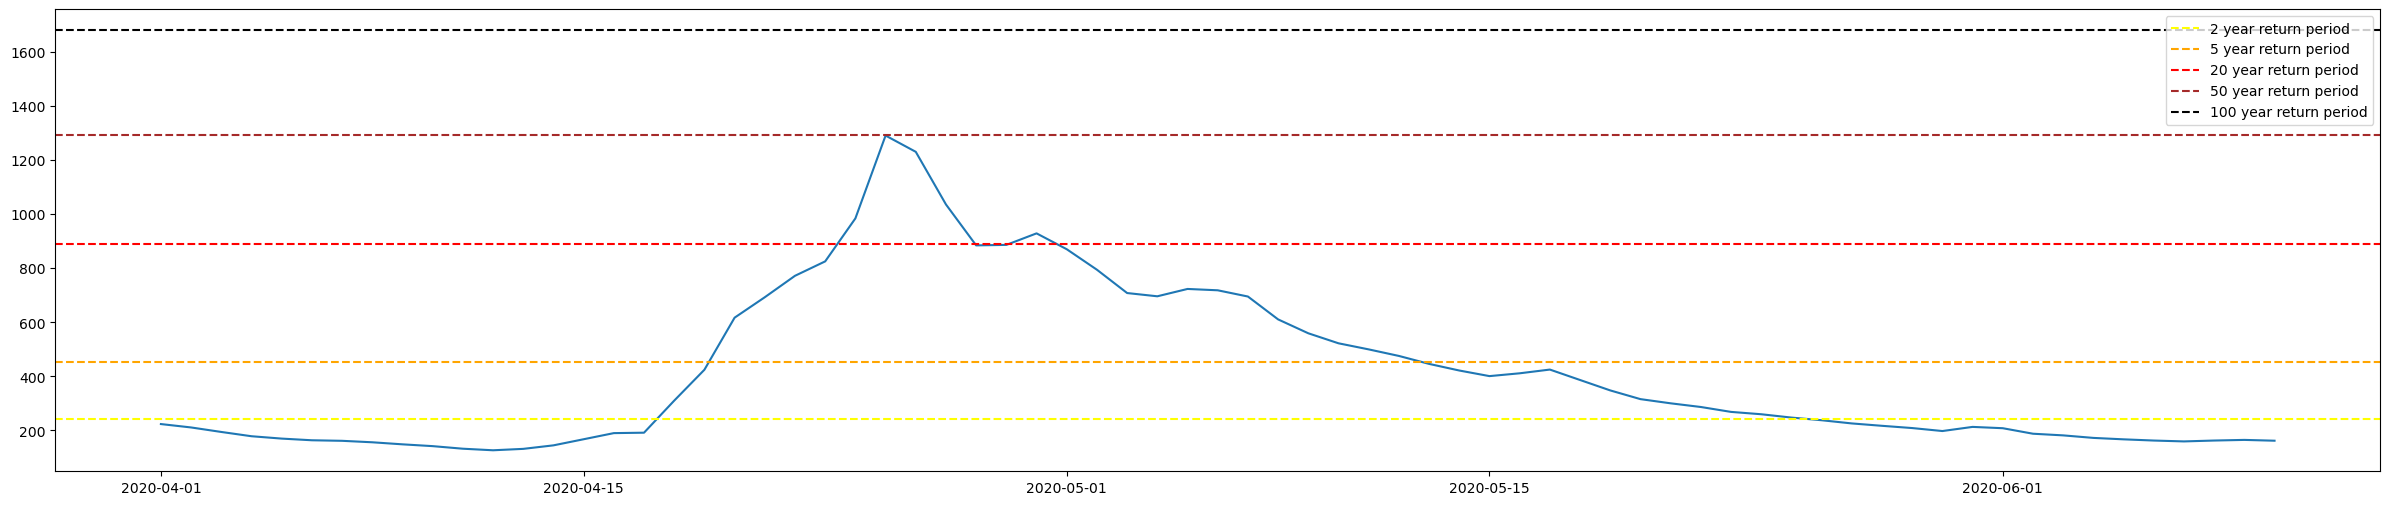

In [95]:
start_date = '2020-04-01'
end_date = '2020-06-10'

plot_reanalysis(start_date, end_date, gauge_return_periods_ds)

##### Plot reforecast

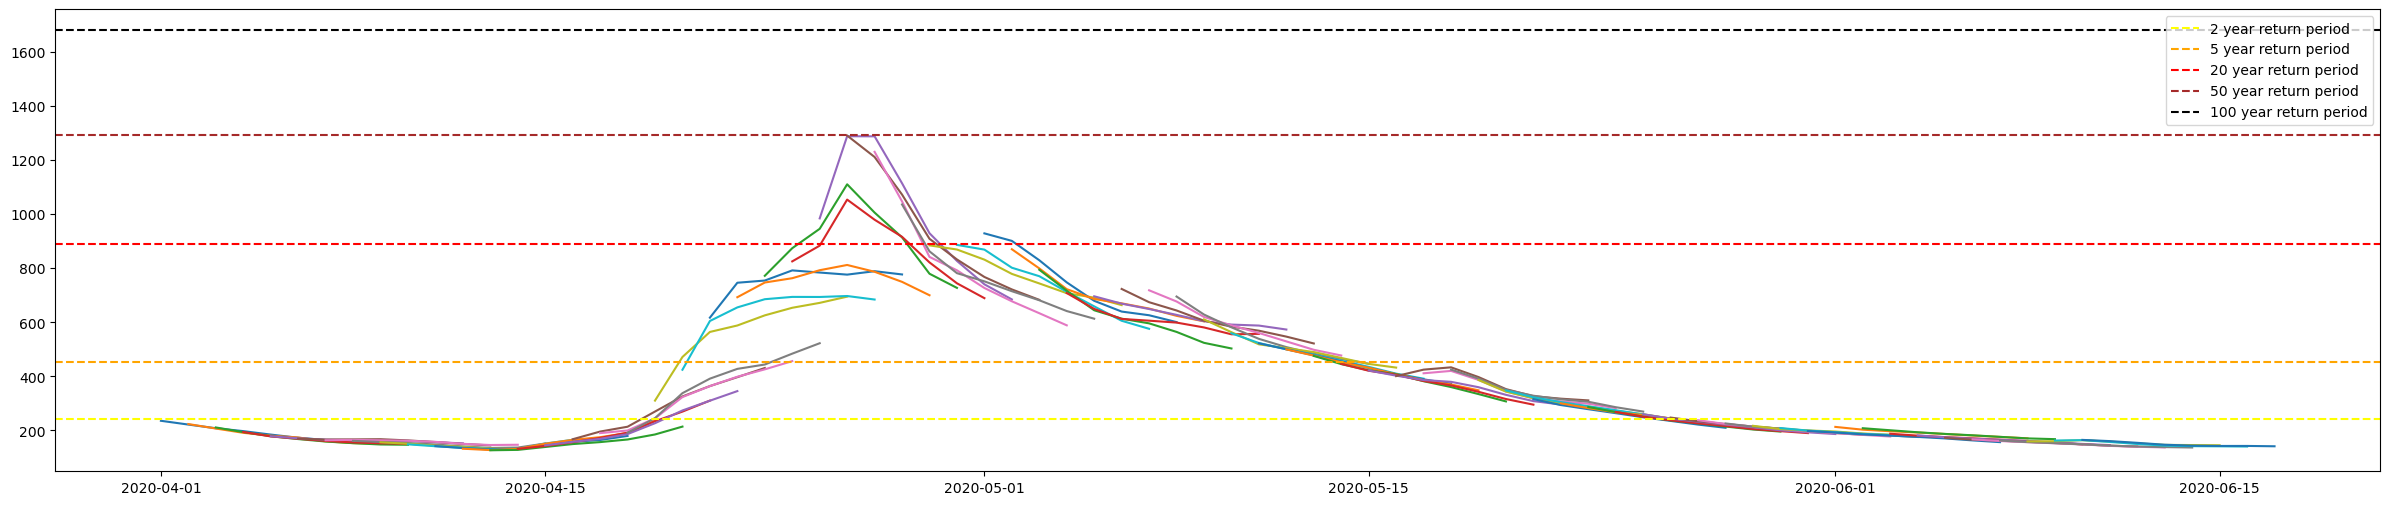

In [96]:
# Plot REFORECAST: 2016-2023
issue_time_start_date = '2020-04-01'
issue_time_end_date = '2020-06-10'

plot_reforecast(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds)

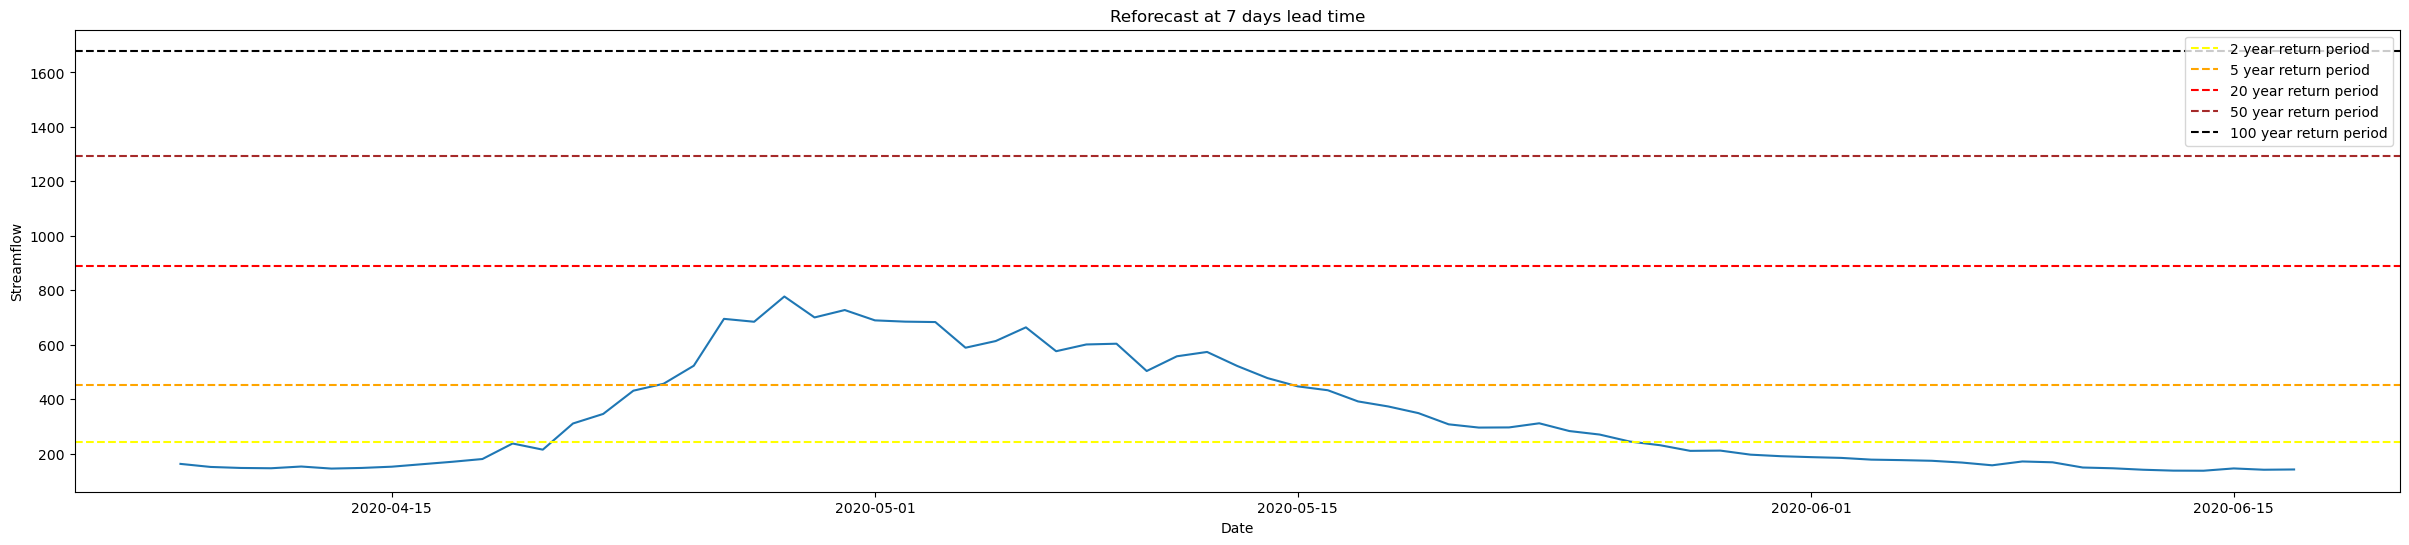

In [98]:
# Plot reforecast with lead time
lead_time = '7 days'
plot_reforecast_leadtime(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds, leadtime=lead_time)

#### Step 5: Verification

##### Showing here that Reanalysis[time=T] == Reforecast[time=T+1, lead_time=0]

In [71]:
gauge_reforecast_ds.sel(issue_time=datetime.datetime(2020, 5, 1)).streamflow.values

array([928.8858 , 901.1077 , 829.4544 , 747.62756, 679.49603, 639.6936 ,
       626.0937 , 600.77594], dtype=float32)

In [73]:
gauge_reanalysis_ds.sel(time=datetime.datetime(2020, 4, 30)).streamflow.item()

928.8858032226562